In [5]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# # Read sqlite query results into a pandas DataFrame
# con = sqlite3.connect("../Data/citibike.sqlite")
# df = pd.read_sql_query("SELECT * FROM allrides where date(starttime)==strftime("2019-07-01"), con)

# # Verify that result of SQL query is stored in the dataframe
# print(df.head())

# con.close()

In [2]:
sample = pd.read_csv('../Data/allrides_sample2.csv')
stations = pd.read_csv('../Data/live_stations.csv')

In [3]:
stations = pd.read_csv('../Data/live_stations.csv')
print(stations.shape)
print(stations.station_id.unique().shape)
print(stations.station_lat.unique().shape)
print(stations.station_long.unique().shape)

(1001, 4)
(895,)
(927,)
(922,)


#### <i>problem 1: start station id has potentially non-unqiue names and lat & long information

In [4]:
print(f'sample size: {sample.shape}')
print(f'sample columns: {sample.columns}')

sample size: (2000000, 15)
sample columns: Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')


### transform Dates

In [7]:
def reformat_date(df):
    datecol=['starttime','stoptime']
    for col in datecol:
        df[col]=pd.to_datetime(sample[col])
        hourcol=col+'_hour'
        mincol=col+'_min'
        datecol=col+'_date'
        df[datecol]=df[col].dt.date
        df[hourcol]=df[col].dt.hour
        df[mincol]=df[col].dt.minute
        df[mincol]=df[mincol].apply(lambda x: 0 if x < 30 else 30)
    df['season']=df['starttime'].dt.month.apply(lambda x: 'winter' if x <=2 else 'spring' if x<=5 else 
                                              'summer' if x<=8 else 'fall' if x<=11 else 'winter')
    df['dayofweek']=df['starttime'].dt.weekday
    df['year']=df['starttime'].dt.year

In [8]:
reformat_date(sample)

In [9]:
sample.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'starttime_date', 'starttime_hour',
       'starttime_min', 'stoptime_date', 'stoptime_hour', 'stoptime_min',
       'season', 'dayofweek', 'year'],
      dtype='object')

### Remove rides from or to old bike stations that no longer exist as of 2019-12-01.

In [82]:
sample_new=sample[sample['start station id'].isin(stations.station_id.unique().tolist())]
sample_new=sample[sample['end station id'].isin(stations.station_id.unique().tolist())]
sample_new=sample[sample['year']!=2020]
sample_new.shape

(1968818, 24)

In [11]:
temp=pd.DataFrame(sample_new.groupby('year')['start station id'].unique())
temp['count']=temp['start station id'].apply(lambda x: len(x))

In [12]:
temp

,start station id,count
year,,
2015,"[368.0, 526.0, 417.0, 446.0, 361.0, 377.0, 489...",485
2016,"[417.0, 3085.0, 261.0, 307.0, 3256.0, 268.0, 1...",638
2017,"[3348.0, 523.0, 442.0, 304.0, 498.0, 3344.0, 3...",790
2018,"[3177.0, 3258.0, 398.0, 3656.0, 267.0, 3686.0,...",805
2019,"[3314.0, 3072.0, 3056.0, 212.0, 3749.0, 514.0,...",924
2020,"[258.0, 3161.0, 493.0, 3058.0, 3078.0, 3242.0,...",875


In [ ]:
# fig= plt.figure(figsize=(12,6))
# fig, axs = plt.subplots(1, 2)
# axs[0].hist(sample2019['starttime_hour'], bins=12)
# axs[1].hist(sample2019['starttime_min'])

## Visualizing Data

### Hourly distribution of rides seem to be very similar across years 2015-2019.
<i> this is great because rides do follow some sort of hourly trend.
- intuitivelly, the chart below makes sense in term of:
    - more rides during weekday.
    - more rides during rush hour.

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


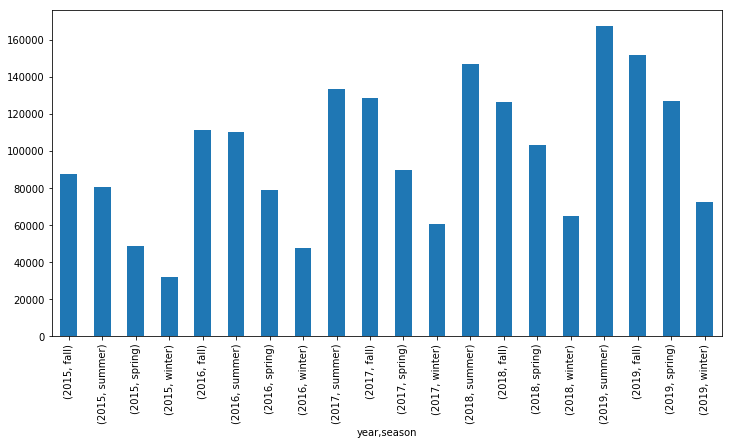

In [84]:
sample_new['season'] = pd.Categorical(sample_new['season'], ["spring", "summer", "fall","winter"])
plt.figure(figsize=(12,6))
sample_new.sort_values("season").groupby('year')['season'].value_counts().plot.bar()

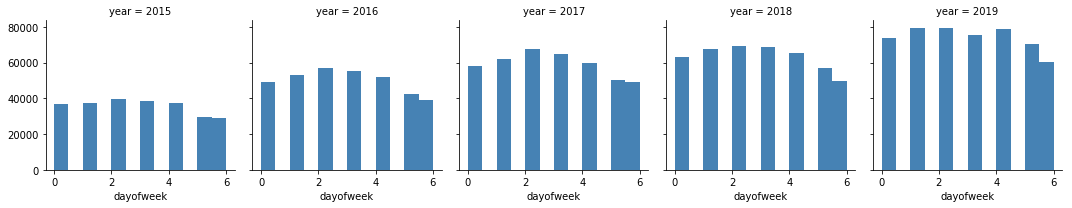

In [85]:
g=sns.FacetGrid(sample_new, col="year", margin_titles=True)
g.map(plt.hist, "dayofweek", color="steelblue", bins=12)

In [ ]:
g=sns.FacetGrid(sample_new, col="year", margin_titles=True)
g.map(plt.hist, "starttime_hour", color="steelblue", bins=12)